# ESN Model Codes

## Dependencies

In [1]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
from reservoirpy import mat_gen, ESN

## Directories:

In [2]:
# training data
train_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/train'
train_dir_video = '/raid/cs152/zxaa2018/penndulum//train_and_test_split/dpc_dataset_traintest_4_200_h264/train'

# test data
test_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_inputs/'
test_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_targets/'
test_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/test_targets/'

# validation data
validation_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_inputs/'
validation_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_targets/'
validation_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/validation_targets/'

## Functions and Class Definitions

### Data Transformation Functions

In [59]:
# some constants
DEFAULT_X_RED, DEFAULT_Y_RED = (240, 232)

PIXEL_DISTANCE_GREEN_TO_RED = 118 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_green-y_red)**2 + (x_green-x_red)**2)
PIXEL_DISTANCE_BLUE_TO_GREEN = 90 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_blue-y_green)**2 + (x_blue-x_green)**2)

def raw_to_pixel(l):
    '''Convert the raw coordinates to pixel coordinates.'''
    assert isinstance(l, list)
    return [x/5 for x in l]


def pixel_to_raw(l):
    '''Convert the pixel coordinates to raw coordinates.'''
    assert isinstance(l, list)
    return [x*5 for x in l]


def raw_cartesian_to_polar_angles(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)

    #angle_green_red = np.arctan((y_green-y_red)/(x_green-x_red+0.001))
    #angle_blue_green = np.arctan((y_blue-y_green)/(x_blue-x_green+0.001))

    angle_green_red = np.arctan2(y_red-y_green+1e-4, x_green-x_red+1e-4) + np.pi * 0.5
    angle_blue_green = np.arctan2(y_green-y_red + 1e-4, x_blue-x_green+0.001) + np.pi * 0.5
    
    return [np.sin(angle_green_red), np.cos(angle_green_red), np.sin(angle_blue_green), np.cos(angle_blue_green)]

def raw_cartesian_to_thetas(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)\

    angle_green_red = np.arctan2(y_red-y_green+1e-4, x_green-x_red+1e-4) + np.pi * 0.5
    angle_blue_green = np.arctan2(y_green-y_red + 1e-4, x_blue-x_green+0.001) + np.pi * 0.5
    
    return [angle_green_red, angle_blue_green]

def polar_angles_to_raw_cartesian(l):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    assert isinstance(l, list)
    sin_angle_green_red, cos_angle_green_red, sin_angle_blue_green, cos_angle_blue_green = l
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green
    
    return pixel_to_raw([DEFAULT_X_RED, DEFAULT_Y_RED, x_green, y_green, x_blue, y_blue])

### Data reading functions

Parsing training data:
training data x-y matching is like this:
x: a list of 4 frames
y: the frame that follows

In [4]:
def parse_csv_esn(csv_file):
    '''Given a csv file and a length of sequence, return the sequence in list of list'''
    X_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        next_frame = raw_cartesian_to_polar_angles(row.to_list())
        X_data.append(next_frame.copy())
        
    return X_data

In [5]:
def parse_csv_esn_angular(csv_file):
    '''Given a csv file and a length of sequence, return the sequence in list of list'''
    X_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        next_frame = row.to_list()
        next_frame = raw_cartesian_to_thetas(next_frame)
        X_data.append(next_frame.copy())
        
    return X_data

In [6]:
def get_seq_list(source_dir):
    result = []
    name = []
    for filename in tqdm([x for x in os.listdir(source_dir) if not x.startswith('.')]):
        # load in a file
        name.append(filename)
        X_data = parse_csv_esn(os.path.join(source_dir, filename))
        result.append(X_data)
    return result, name

In [7]:
def normalize_sequence(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of x coords 0,2,4
    x_factor = (sequence[:,[0,2,4]].max() - sequence[:,[0,2,4]].min()) * 0.5
    y_factor = (sequence[:,[1,3,5]].max() - sequence[:,[1,3,5]].min()) * 0.5

    sequence[:,[0,2,4]] = sequence[:,[0,2,4]] / max(x_factor,1e-6) - 0.5
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] / max(y_factor, 1e-6) - 0.5

    return sequence, (x_factor, y_factor)

def denormalize_sequence(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[0,2,4]] = (sequence[:,[0,2,4]] + 0.5) * factors[0]
    sequence[:,[1,3,5]] = (sequence[:,[1,3,5]] + 0.5) * factors[1]

    return sequence
    

In [8]:
def normalize_sequence_by_pivot(sequence: np.ndarray):
    '''Given a sequence in shape (n,6), normalize the sequence to [-1,1]'''
    # get range of coords of first  axis
    a_factor = (sequence[:,[0,1]].max() - sequence[:,[0,1]].min()) * 0.5
    b_factor = (sequence[:,[2,3]].max() - sequence[:,[2,3]].min()) * 0.5
    c_factor = (sequence[:,[4,5]].max() - sequence[:,[4,5]].min()) * 0.5

    a_shift = sequence[:,[0,1]].min()
    b_shift = sequence[:,[2,3]].min()
    c_shift = sequence[:,[4,5]].min()

    sequence[:,[0,1]] = (sequence[:,[0,1]] - a_shift) / max(a_factor,1e-6) - 1
    sequence[:,[2,3]] = (sequence[:,[2,3]] - b_shift) / max(b_factor,1e-6) - 1
    sequence[:,[4,5]] = (sequence[:,[4,5]] - c_shift) / max(c_factor,1e-6) - 1

    sequence[:,[0,2,4]] = sequence[:,[0,2,4]] * -1.0

    return sequence, (a_factor, b_factor, c_factor, a_shift, b_shift, c_shift)

def denormalize_sequence_by_pivot(sequence: np.array, factors: tuple):
    '''Given a sequence in shape (n,6), normalized to [-1,1], and the normalize factors along the x, y axis, return the denormalized sequence'''
    sequence[:,[1,3,5]] = sequence[:,[1,3,5]] * -1.0
    sequence[:,[0,1]] = (sequence[:,[0,1]] + 1) * factors[0] + factors[3]
    sequence[:,[2,3]] = (sequence[:,[0,1]] + 1) * factors[1] + factors[4]
    sequence[:,[4,5]] = (sequence[:,[0,1]] + 1) * factors[2] + factors[5]

    return sequence

In [9]:
def make_data_continuous(seq: np.array):
    for i,datapoint in enumerate(seq[:,0][:-1]):
        if seq[:,0][i+1] - datapoint > np.pi * 2 - 0.1:
            seq[:,0][i+1:] -= np.pi * 2
        elif datapoint - seq[:,0][i+1] > np.pi * 2 - 0.1:
            seq[:,0][i+1:] += np.pi * 2
        else:
            continue
    for i,datapoint in enumerate(seq[:,1][:-1]):
        if seq[:,1][i+1] - datapoint > np.pi * 2 - 0.1:
            seq[:,1][i+1:] -= np.pi * 2
        elif datapoint - seq[:,1][i+1] > np.pi:
            seq[:,1][i+1:] += np.pi * 2
        else:
            continue
    return seq
    


### Dataset Definition

In [10]:
class NormalizedDataset():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.factor_list = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            self.name_dict[i] = name
            norm_seq, factors = normalize_sequence_by_pivot(np.array(seq, dtype=float))
            self.sample_List.append(norm_seq)
            self.factor_list.append(factors)

    def __len__(self):
        return len(self.sample_list)
    
    def getFactor(self, index: int):
        return self.x_factor_list[index], self.y_factor_list[index]

In [11]:
class Dataset():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            self.name_dict[i] = name
            self.sample_List.append(np.array(seq, dtype=np.float32))

    def __len__(self):
        return len(self.sample_list)

In [12]:
class DoublePendulumDataset(torch.utils.data.Dataset):
    '''
    Generate a LSTM dataset from a normalized dataset
    '''
    def __init__(self,dataset_n:NormalizedDataset):
        self.X_list = []
        self.y_list = []
        for seq in tqdm(dataset_n.sample_List):
            for i in range(seq.shape[0] - 5):
                self.X_list.append(torch.from_numpy(seq[[i,i+1,i+2,i+3],:]))
                self.y_list.append(torch.from_numpy(seq[[i+4],:]))
        self.sample_list = list(zip(self.X_list, self.y_list))

    
    def __getitem__(self,index):
        X_sample,y_sample = self.sample_list[index]
        return torch.from_numpy(np.array(X_sample)).float(),torch.from_numpy(np.array(y_sample)).float()
    
    def __len__(self):
        return len(self.sample_list)

In [13]:
class AngularDatast():
    def __init__(self,X_list: list, name_list: list):
        self.sample_List = []
        self.name_dict = {}
        for i, (seq, name) in enumerate(zip(X_list, name_list)):
            seq_c = make_data_continuous(np.array(seq, dtype=float))
            self.name_dict[i] = name
            self.sample_List.append(seq_c)

    def __len__(self):
        return len(self.sample_list)

### Model Definition

Data Visualization Functions

In [14]:
def plot_comparison_with_warmup(Xgen, Xgen_test, warm_up, length, axis1, axis2):
    t = np.arange(length)
    fig = plt.figure(figsize = (13,5))
    
    plt.gca().invert_yaxis()
    plt.subplot((121))
    plt.title(f"Ground Truth, first {length} frame")
    plt_x = [y[1] for y in Xgen_test[:,[axis1, axis2][:length]]]
    plt_y = [y[0] for y in Xgen_test[:,[axis1, axis2][:length]]]
    warm_x = [y[1] for y in warm_up[:,[axis1, axis2]]]
    warm_y = [y[0] for y in warm_up[:,[axis1, axis2]]]

    plt.plot(warm_x, warm_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(warm_x, warm_y,lw=0.5, c = 'red', s=2)
    plt.plot(plt_x, plt_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x, plt_y,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=2)
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

    plt.subplot((122))
    plt.title(f"Prediction, first {length} frame")
    plt_x_res = [y[1] for y in Xgen[:,[axis1, axis2]][:length]]
    plt_y_res = [y[0] for y in Xgen[:,[axis1, axis2]][:length]]

    plt.plot(warm_x, warm_y, lw=1,color="lightgrey", zorder=0)
    plt.scatter(warm_x, warm_y,lw=0.5, c = 'red', s=2)
    plt.plot(plt_x_res, plt_y_res, lw=1,color="lightgrey", zorder=0)
    plt.scatter(plt_x_res, plt_y_res,lw=0.5, c = t[:len(plt_x)],cmap="viridis", s=2)
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")

In [15]:
def plot_sequence(seq, a1, a2):

    length = seq.shape[0]
    t = np.arange(length)
    
    plt.title(f"Timeserie - {length} timesteps")

    plt.plot(seq[:,a2], seq[:,a1], color="lightgray", zorder=0)
    plt.scatter(seq[:,a2], seq[:,a1], c=t[:length], cmap="viridis", s=1, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

## Training, testing and analysis Codes

### Loading Training Data

In [60]:
Seq_train_p, Seq_train_name_p = get_seq_list(train_dir)
dataset_p = Dataset(Seq_train_p, Seq_train_name_p)

100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


### Hyperparameter and Model instantiate

In [19]:
class ESNModel():
    def __init__(self, units, dim, input_scaling, input_connectivity, input_bias, seed, spectral_radius, density, leak_rate, regularization):
        self.units = units
        self.dim = dim
        self.input_scaling = input_scaling
        self.input_connectivity = input_connectivity
        self.input_bias = input_bias
        self.seed = seed
        self.spectral_radius = spectral_radius
        self.density = density
        self.leak_rate = leak_rate
        self.regularization = regularization
        
        self.Win = mat_gen.generate_input_weights(self.units, self.dim,    input_scaling=self.input_scaling, proba=self.input_connectivity, input_bias=self.input_bias,seed=self.seed)
        self. W = mat_gen.generate_internal_weights(self.units, sr=self.spectral_radius, proba=self.density, seed=self.seed)
        self.reservior = ESN(self.leak_rate, self.W, self.Win, ridge = self.regularization)

    def train_on_sequence(self, dataset: NormalizedDataset, index = 0, train_length = 400, forecast = 1):
        '''
        Given an index of of a sequence in the dataset (default to 0), train the reservoir on that sequence.
        '''
        seq = dataset.sample_List[index]
        states = self.reservior.train(seq[:train_length], seq[forecast: forecast + train_length], verbose = False)
        return states

    def generate_on_sequence(self, dataset: NormalizedDataset, index = 0, warm_up_length = 100, nb_generations = 200, start = 0):
        '''Given a sequence of a dataset, generate on that sequence'''
        test_X = dataset.sample_List[index]
        warming_inputs = test_X[start: start + warm_up_length]
        Xgen_test = test_X[start + warm_up_length : start + nb_generations + warm_up_length]
        Xgen, states, warming_out, warming_states = self.reservior.generate(nb_generations, warming_inputs=warming_inputs, verbose = False)
        return Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states

    def reset(self):
        '''reset the model'''
        self.Win = mat_gen.generate_input_weights(self.units, self.dim,    input_scaling=self.input_scaling, proba=self.input_connectivity, input_bias=self.input_bias,seed=self.seed)
        self. W = mat_gen.generate_internal_weights(self.units, sr=self.spectral_radius, proba=self.density, seed=self.seed)
        self.reservior = ESN(self.leak_rate, self.W, self.Win, ridge = self.regularization)

In [20]:
def plot_time_series(seq, a1, l):

    #length = seq.shape[0]
    t = np.linspace(0, l - 1, l)
     
    plt.title(f"Timeserie - {l} timesteps")

    plt.plot(t, seq[:,a1][:l], color="lightgray", zorder=0)
    plt.scatter(t, seq[:,a1][:l], c=t[:l], cmap="viridis", s=1, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    plt.tight_layout()
    plt.show()

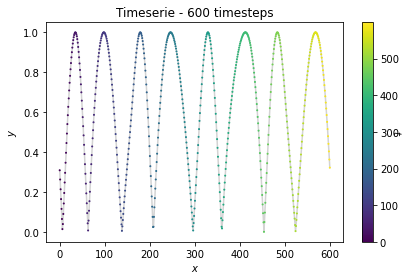

In [21]:
plot_time_series(dataset_p.sample_List[3], 1, 600)

Task:
- write a function quantifying error for each prediction.
  let's use the Y distance
- train with different number of sequences, and test. (Maybe test on #39).

In [22]:
def error_seq(Xgen, Xgen_test):
    '''
    Given ground truth and prediction, calculate the mean distance between the endpoints and then the percentage error with respect to the range the endpoints can move (2.0).
    '''
    diff = Xgen - Xgen_test
    dist = np.sqrt(np.square(diff[:,4])+np.square(diff[:,5]))
    DIST_CENTER = 2.0
    min_off_center_percentage = np.mean(dist) / DIST_CENTER
    return min_off_center_percentage

100%|██████████| 39/39 [01:45<00:00,  2.69s/it]


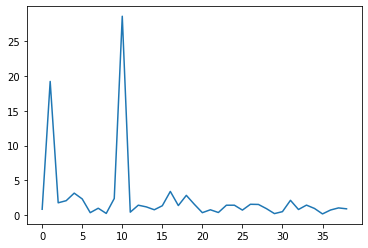

In [61]:
'''
Defining our hyperparameters.
'''

units = 500
leak_rate = 0.1
spectral_radius = 25.0
input_scaling = 0.5
density = 0.1
input_connectivity = 1.0
regularization = 1e-7
seed = 1000

model = ESNModel(units=units, dim=4, input_scaling=input_scaling, input_connectivity=input_connectivity, input_bias= True, seed = seed, spectral_radius= spectral_radius, density=density, leak_rate=leak_rate, regularization= regularization)

error_list = []
model.reset()
for i in tqdm(range(39)):
    states = model.train_on_sequence(dataset_p, i, train_length = dataset_p.sample_List[i].shape[0]-1,forecast= 1)
    Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states = model.generate_on_sequence(dataset_p, 39, warm_up_length=20, nb_generations=50)
    error_list.append(((Xgen - Xgen_test) ** 2).mean(axis=None))
    model.reset()
plt.plot(error_list)

### Analyzing

This following graph is the MSE after training on each sequence.

100%|██████████| 39/39 [01:24<00:00,  2.17s/it]


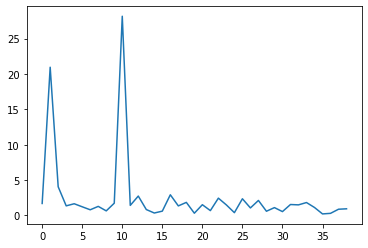

In [62]:
error_list_cummulative = []
model.reset()
for i in tqdm(range(39)):
    states = model.train_on_sequence(dataset_p, i, train_length = dataset_p.sample_List[i].shape[0]-1,forecast= 1)
    Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states = model.generate_on_sequence(dataset_p, 39, warm_up_length=20, nb_generations=50)
    error_list_cummulative.append(((Xgen - Xgen_test) ** 2).mean(axis=None))
plt.plot(error_list_cummulative)

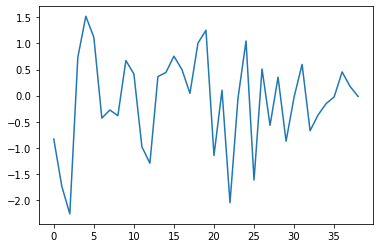

In [75]:
c = []
for e1, e2 in zip(error_list,error_list_cummulative):
    c.append(e1-e2)
plt.plot(c)

We notice that in fact error does not grow with increasing training data. In fact, it fluctuates randomly. It is also very correlated with how far the first prediction jumps.

Suprisingly, the MSE for independent training and cummulative training are quite random, which means the size of training dataset does not affect the training result and model performance.

Must be a hyperparam issue?.

### Comments on testing the ESN.

We observe that the more data we train the ESN on, it appears, the more error it has. Often it ends in to a sort of circular motion.

One hypothesis on why such is the case is that, as we observe, the overall motion of the endpoint is something like this:

100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


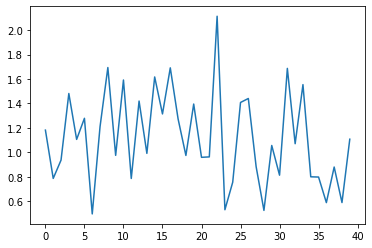

In [67]:
test_errors = []
for i in tqdm(range(40)):
    Xgen, Xgen_test, warming_inputs, states, warming_out, warming_states = model.generate_on_sequence(dataset_p, i, warm_up_length=100, nb_generations=200)
    test_errors.append(((Xgen - Xgen_test)**2).mean(axis=None))
plt.plot(test_errors)

Overall, the sequence does not show a significant difference in easyness to predict.

In [51]:
def polar_to_cartesian_np(arr: np.ndarray):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    sin_angle_green_red, cos_angle_green_red, sin_angle_blue_green, cos_angle_blue_green = arr[:,0],arr[:,1],arr[:,2],arr[:,3]
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green

    x_red = np.ones_like(x_green) * DEFAULT_X_RED
    y_red = np.ones_like(y_green) * DEFAULT_Y_RED
    
    return np.column_stack((x_red,y_red,x_green, y_green,x_blue, y_blue))*5.0

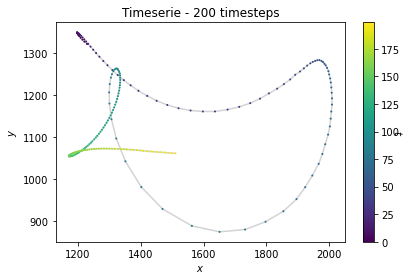

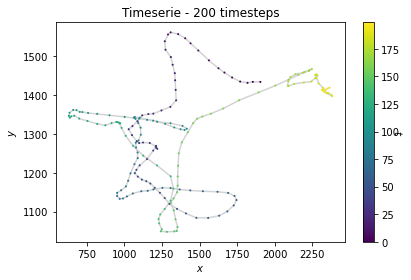

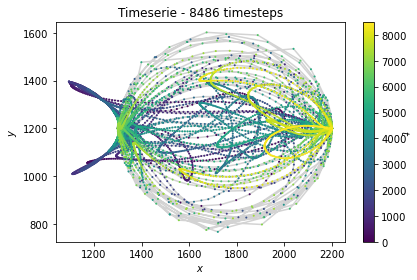

In [66]:
truth = polar_to_cartesian_np(Xgen_test)
predict = polar_to_cartesian_np(Xgen)
plot_sequence(truth, 4, 5)
plot_sequence(predict, 4, 5)
plot_sequence(polar_to_cartesian_np(dataset_p.sample_List[39]), 4,5)

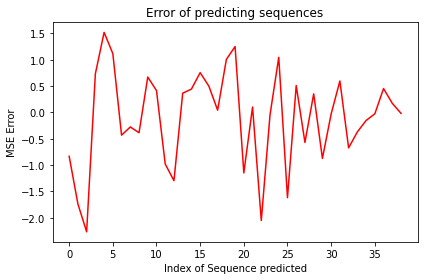

In [77]:
plt.title(f"Error of predicting sequences")
plt.plot(c, color="red", zorder=0)
plt.xlabel("Index of Sequence predicted")
plt.ylabel("MSE Error")
plt.tight_layout()
plt.show()